In [395]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

import pickle
from tqdm import tqdm
import os

In [396]:
#Loading 'glove_vectors
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

# **1.Desicion Tree**

**1.1 Loading Dataset**

In [397]:
#Taking datapoints as 50k
data = pd.read_csv('preprocessed_data.csv')
data.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [398]:
#Checking the column names for the dataset
data.columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price'],
      dtype='object')

** 1.2 Calculating Sentiment Scores : essay feature**

In [399]:
#Calculating sentiment scores using vader lexicon
import nltk
nltk.download('vader_lexicon')

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

#initializing empty set for each of the polarities
pos = []
neg = []
neu = []
compound = []

for i in tqdm(range(len(data['essay']))):
    sentiment_scores = sid.polarity_scores(data['essay'][i])
    neg.append(sentiment_scores['neg'])
    pos.append(sentiment_scores['pos'])
    neu.append(sentiment_scores['neu'])    
    compound.append(sentiment_scores['compound'])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\amakh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109248/109248 [06:46<00:00, 268.51it/s]


In [400]:
#Adding new columns on the dataset for each of the sentiment scores for feature : essay

data['neg'] = neg
data['neu'] = neu
data['pos'] = pos
data['compound'] = compound

 **1.3 Splitting the data**

In [401]:
#Taking "project_is_approved" as y and all other features as x

y = data["project_is_approved"].values
x = data.drop(["project_is_approved"],axis=1)

In [402]:
from sklearn.model_selection import train_test_split
#Taking test data as 30%
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)



(76473, 12) (76473,)
(32775, 12) (32775,)


**1.4 Encoding of numerical features**

**1.4.1 Encoding of numerical features : teacher_number_of_previously_posted_projects** 

In [403]:
#Scaling the numerical features
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
x_train_no_pre_projects_normalized = normalizer.transform(x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
x_test_no_pre_projects_normalized = normalizer.transform(x_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

#Checking if the train and test data size remains same after applying normalization

print(x_train_no_pre_projects_normalized.shape)
print(x_test_no_pre_projects_normalized.shape)

(76473, 1)
(32775, 1)


**1.4.2 Encoding of numerical features : price**

In [404]:
#Scaling the numerical features

normalizer = Normalizer()
normalizer.fit(x_train['price'].values.reshape(-1,1))
x_train_price_normalized = normalizer.transform(x_train['price'].values.reshape(-1,1))
x_test_price_normalized = normalizer.transform(x_test['price'].values.reshape(-1,1))

#Checking if the train and test data size remains same after applying normalization

print(x_train_price_normalized.shape)
print(x_test_price_normalized.shape)

(76473, 1)
(32775, 1)


**1.4.3 Encoding of numerical features : Sentiment scores**

In [405]:
#Scaling the numerical features

normalizer = Normalizer()
normalizer.fit(x_train['pos'].values.reshape(-1,1))
x_train_pos_normalized = normalizer.transform(x_train['pos'].values.reshape(-1,1))
x_test_pos_normalized = normalizer.transform(x_test['pos'].values.reshape(-1,1))

#Checking if the train and test data size remains same after applying normalization

print(x_train_pos_normalized.shape)
print(x_test_pos_normalized.shape)

(76473, 1)
(32775, 1)


In [406]:
#Scaling the numerical features

normalizer = Normalizer()
normalizer.fit(x_train['neg'].values.reshape(-1,1))
x_train_neg_normalized = normalizer.transform(x_train['neg'].values.reshape(-1,1))
x_test_neg_normalized = normalizer.transform(x_test['neg'].values.reshape(-1,1))

#Checking if the train and test data size remains same after applying normalization

print(x_train_neg_normalized.shape)
print(x_test_neg_normalized.shape)

(76473, 1)
(32775, 1)


In [407]:
#Scaling the numerical features

normalizer = Normalizer()
normalizer.fit(x_train['neu'].values.reshape(-1,1))
x_train_neu_normalized = normalizer.transform(x_train['neu'].values.reshape(-1,1))
x_test_neu_normalized = normalizer.transform(x_test['neu'].values.reshape(-1,1))

#Checking if the train and test data size remains same after applying normalization

print(x_train_neu_normalized.shape)
print(x_test_neu_normalized.shape)

(76473, 1)
(32775, 1)


In [408]:
#Scaling the numerical features

normalizer = Normalizer()
normalizer.fit(x_train['compound'].values.reshape(-1,1))
x_train_compound_normalized = normalizer.transform(x_train['compound'].values.reshape(-1,1))
x_test_compound_normalized = normalizer.transform(x_test['compound'].values.reshape(-1,1))

#Checking if the train and test data size remains same after applying normalization

print(x_train_compound_normalized.shape)
print(x_test_compound_normalized.shape)

(76473, 1)
(32775, 1)


**1.5 Encoding of categorical features**

**1.5.1 Encoding of categorical features : school_state**

In [409]:
#Performing one hot encoding on categorical features
vectorizer = CountVectorizer()
x_train_school_state_encoded = vectorizer.fit_transform(x_train['school_state'].values)
x_test_school_state_encoded = vectorizer.fit_transform(x_test['school_state'].values)

#Checking if the train and test data size remains same after applying one hot encoding
print(x_train_school_state_encoded.shape)
print(x_test_school_state_encoded.shape)

(76473, 51)
(32775, 51)


**1.5.2 Encoding of categorical features : teacher_prefix**

In [410]:
#Performing one hot encoding on categorical features

vectorizer = CountVectorizer()
x_train_teacher_prefix_encoded = vectorizer.fit_transform(x_train['teacher_prefix'].values)
x_test_teacher_prefix_encoded = vectorizer.fit_transform(x_test['teacher_prefix'].values)

#Checking if the train and test data size remains same after applying one hot encoding
print(x_train_teacher_prefix_encoded.shape)
print(x_test_teacher_prefix_encoded.shape)

(76473, 5)
(32775, 5)


**1.4.3 Encoding of categorical features : project_grade_category**

In [411]:
#Performing one hot encoding on categorical features

vectorizer = CountVectorizer()

x_train_project_grade_category_encoded = vectorizer.fit_transform(x_train['project_grade_category'].values)
x_test_project_grade_category_encoded = vectorizer.fit_transform(x_test['project_grade_category'].values)

#Checking if the train and test data size remains same after applying one hot encoding
print(x_train_project_grade_category_encoded.shape)
print(x_test_project_grade_category_encoded.shape)

(76473, 4)
(32775, 4)


**1.4.4 Encoding of categorical features : clean_categories**

In [412]:
#Performing one hot encoding on categorical features

vectorizer = CountVectorizer()

x_train_clean_categories_encoded = vectorizer.fit_transform(x_train['clean_categories'].values)
x_test_clean_categories_encoded = vectorizer.fit_transform(x_test['clean_categories'].values)

#Checking if the train and test data size remains same after applying one hot encoding
print(x_train_clean_categories_encoded.shape)
print(x_test_clean_categories_encoded.shape)

(76473, 9)
(32775, 9)


**1.4.5 Encoding of categorical features : clean_subcategories**

In [413]:
#Performing one hot encoding on categorical features

vectorizer = CountVectorizer()

x_train_clean_subcategories_encoded = vectorizer.fit_transform(x_train['clean_subcategories'].values)
x_test_clean_subcategories_encoded = vectorizer.fit_transform(x_test['clean_subcategories'].values)

#Checking if the train and test data size remains same after applying one hot encoding
print(x_train_clean_subcategories_encoded.shape)
print(x_test_clean_subcategories_encoded.shape)

(76473, 30)
(32775, 30)


**1.5.1 Applying TFIDF vectorizer on essay feature**

In [414]:
#TFIDF vectozier on text data
essay_tfidf_vectorizer = TfidfVectorizer(min_df= 10,max_features= 5000)
essay_tfidf_vectorizer.fit(x_train['essay'].values)

#converting text to vector using vectorizer
x_train_essay_tfidf = essay_tfidf_vectorizer.transform(x_train['essay'].values)
x_test_essay_tfidf = essay_tfidf_vectorizer.transform(x_test['essay'].values)

#Checking if the train and test data size remains same after applying one hot encoding

print(x_train_essay_tfidf.shape)
print(x_test_essay_tfidf.shape)

(76473, 5000)
(32775, 5000)


**1.5.2 Applying TFIDF W2V on essay feature**

In [415]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(x_train["essay"].values)
#Converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [416]:
# average Word2Vec
# computing average word2vec for each review in x_train
tfidf_w2v_essay_x_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(x_train["essay"]): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_essay_x_train.append(vector)

print(len(tfidf_w2v_essay_x_train))
print(len(tfidf_w2v_essay_x_train[0]))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 76473/76473 [06:10<00:00, 206.42it/s]

76473
300


In [417]:
# average Word2Vec
# computing average word2vec for each review in x_test
tfidf_w2v_essay_x_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(x_test["essay"]): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_essay_x_test.append(vector)

print(len(tfidf_w2v_essay_x_test))
print(len(tfidf_w2v_essay_x_test[0]))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32775/32775 [02:34<00:00, 211.68it/s]

32775
300


**1.6 Concatenating features : Set 1 (categorical, numerical features + essay (TFIDF) + Sentiment scores(essay))**

In [418]:
#Using hstack to conact the features

from scipy.sparse import hstack
x_train_set1 = hstack((x_train_no_pre_projects_normalized,x_train_price_normalized,x_train_pos_normalized,x_train_neg_normalized,x_train_neu_normalized,x_train_compound_normalized,x_train_school_state_encoded,x_train_teacher_prefix_encoded,x_train_project_grade_category_encoded,x_train_clean_categories_encoded,x_train_clean_subcategories_encoded,x_train_essay_tfidf)).tocsr()
x_test_set1 = hstack((x_test_no_pre_projects_normalized,x_test_price_normalized,x_test_pos_normalized,x_test_neg_normalized,x_test_neu_normalized,x_test_compound_normalized,x_test_school_state_encoded,x_test_teacher_prefix_encoded,x_test_project_grade_category_encoded,x_test_clean_categories_encoded,x_test_clean_subcategories_encoded,x_test_essay_tfidf)).tocsr()

print("Concated Data Matrix")

print(x_train_set1.shape,y_train.shape)
print(x_test_set1.shape,y_test.shape)

Concated Data Matrix
(76473, 5105) (76473,)
(32775, 5105) (32775,)


**1.6.1 hyper paramter tuning on Set 1**

In [419]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

DT_1 = DecisionTreeClassifier(class_weight= 'balanced')

#best `depth` in range [1, 3, 10, 30], and the best `min_samples_split` in range [5, 10, 100, 500]
#Parameters for GridSearchCV

max_depth = [1, 3, 10, 30]
min_samples_split = [5,10,100,500]

parameters = {"max_depth" :[1, 3, 10, 30], "min_samples_split" : [5,10,100,500]}

clf_1 = GridSearchCV(DT_1, parameters, cv=3, scoring='roc_auc',return_train_score = True)
clf_1.fit(x_train_set1,y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 3, 10, 30], 'min_samples_split': [5, 10, 100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [420]:
#interpreting the results of GridSearchCV
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html 

print("best score :",clf_1.best_score_)
print("best parameter:",clf_1.best_params_)

best score : 0.6296909517479102
best parameter: {'max_depth': 10, 'min_samples_split': 500}


In [421]:
#Checking the Train and Test AUC scores
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

print('Train AUC scores:')
print(clf_1.cv_results_['mean_train_score'])

print('Test AUC scores:')
print(clf_1.cv_results_['mean_test_score'])

Train AUC scores:
[0.5529175  0.5529175  0.5529175  0.5529175  0.5938408  0.5938408
 0.5938408  0.5938408  0.71479301 0.71375722 0.70118771 0.6840655
 0.94474876 0.93763655 0.87322016 0.79850324]
Test AUC scores:
[0.55241595 0.55241595 0.55241595 0.55241595 0.58566437 0.58566437
 0.58566437 0.58566437 0.62341933 0.62312073 0.62455842 0.62969095
 0.56133564 0.56307147 0.58097804 0.60328861]


In [422]:
#creating dataframe to summarize the results of GridSearchCV
results = pd.DataFrame.from_dict(clf_1.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,1.831784,0.191261,0.129568,0.020659,1,5,"{'max_depth': 1, 'min_samples_split': 5}",0.548004,0.555024,0.554221,0.552416,0.003137,13,0.554125,0.552064,0.552563,0.552917,0.000878
1,1.764535,0.060033,0.123862,0.014037,1,10,"{'max_depth': 1, 'min_samples_split': 10}",0.548004,0.555024,0.554221,0.552416,0.003137,13,0.554125,0.552064,0.552563,0.552917,0.000878
2,1.831272,0.061496,0.125996,0.008700,1,100,"{'max_depth': 1, 'min_samples_split': 100}",0.548004,0.555024,0.554221,0.552416,0.003137,13,0.554125,0.552064,0.552563,0.552917,0.000878
3,1.833488,0.073087,0.125031,0.003197,1,500,"{'max_depth': 1, 'min_samples_split': 500}",0.548004,0.555024,0.554221,0.552416,0.003137,13,0.554125,0.552064,0.552563,0.552917,0.000878
4,4.173292,0.050303,0.120777,0.005578,3,5,"{'max_depth': 3, 'min_samples_split': 5}",0.589623,0.581781,0.585589,0.585664,0.003202,6,0.603643,0.588913,0.588967,0.593841,0.006931


**1.6.1.1 Plotting the results using heatmap**

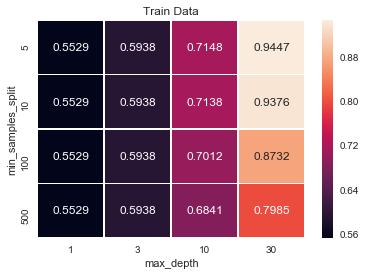

In [423]:
#heatmaps with rows as min_sample_split, columns as max_depth, and values inside the cell representing AUC Score
#https://seaborn.pydata.org/generated/seaborn.heatmap.html 

np.random.seed(0)
sns.set()

#heatmap on train data
heatmap_data = pd.DataFrame({'min_samples_split': results["param_min_samples_split"], 'max_depth': results["param_max_depth"] , 'Z': results["mean_train_score"]})
heatmap_data = heatmap_data.pivot("min_samples_split","max_depth","Z")
hm= sns.heatmap(heatmap_data, annot= True, fmt= ".4f",linewidths=.5)

plt.title("Train Data")
plt.show()

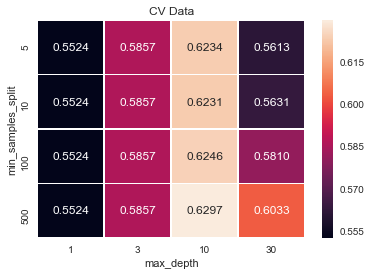

In [424]:
#heatmap on cv data
heatmap_data = pd.DataFrame({'min_samples_split': results["param_min_samples_split"], 'max_depth': results["param_max_depth"] , 'Z': results["mean_test_score"]})
heatmap_data = heatmap_data.pivot("min_samples_split","max_depth","Z")
hm= sns.heatmap(heatmap_data, annot= True, fmt= ".4f",linewidths=.5)

plt.title("CV Data")
plt.show()

**1.6.1.2 Finding best parameters and fit the model**

In [425]:
#Finding the best parameters from classifier clf_1

best_max_depth= clf_1.best_params_['max_depth']
best_min_samples_split= clf_1.best_params_['min_samples_split']

print("best_max_depth= ",best_max_depth)
print("best_min_samples_split= ",best_min_samples_split)

best_max_depth=  10
best_min_samples_split=  500


In [426]:
#https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

DT_set1 = DecisionTreeClassifier(max_depth= best_max_depth, min_samples_split= best_min_samples_split ,class_weight='balanced')
DT_set1.fit(x_train_set1,y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

**1.6.1.3 Plotting ROC-AUC curve using predict proba method **

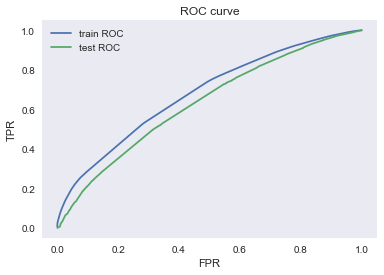

In [427]:
y_train_predicted = DT_set1.predict_proba(x_train_set1)[:,1] 
y_test_predicted = DT_set1.predict_proba(x_test_set1)[:,1]
ytest_predicted = DT_set1.predict(x_test_set1)

train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_predicted)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_predicted)

plt.plot(train_fpr, train_tpr,label="train ROC")
plt.plot(test_fpr, test_tpr,label="test ROC")
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.grid()
plt.show()


In [428]:
#Finding the area under curve ROC = AUC

train_AUC = auc(train_fpr, train_tpr)
test_AUC = auc(test_fpr, test_tpr)

print("AUC for train data :",train_AUC)
print("AUC for test data :",test_AUC)
               

AUC for train data : 0.6793616564918918
AUC for test data : 0.6303379583924639


**1.6.1.4 Confusion Matrix**

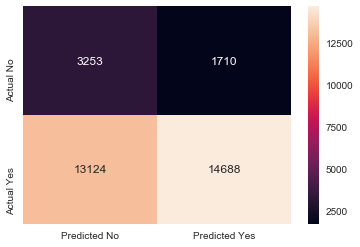

In [429]:
from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(y_test, ytest_predicted)
sns.heatmap(cm_test, annot=True,fmt="d",xticklabels= ['Predicted No', 'Predicted Yes'], yticklabels= ['Actual No','Actual Yes'])

In [430]:
#Getting all the false positive values

false_positive_data = []
for i in range (len(y_test)):
    if (y_test[i] == 0) & (ytest_predicted[i] == 1):
        false_positive_data.append(i)

#checking if the false positive value count matches with that on confusion matrix
print(len(false_positive_data))

1710


In [431]:
#getting the corresponding false positive words from "essay"
false_positive_essay1= []
for i in false_positive_data:
    false_positive_essay1.append(x_test['essay'].values[i])
    
#checking if the false positive value count matches with that on confusion matrix    
print(len(false_positive_essay1))

1710


**1.6.1.5 Plotting WordCloud with the false positive data points on essay feature**

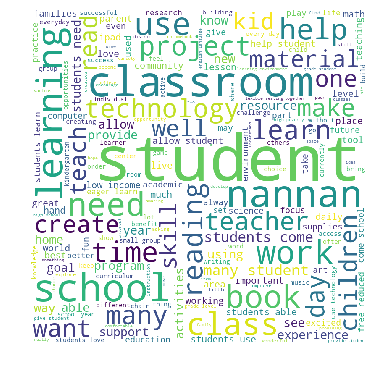

In [432]:
# https://www.geeksforgeeks.org/generating-word-cloud-python/

from wordcloud import WordCloud, STOPWORDS
comment_words = ''
stopwords = set(STOPWORDS)
# iterating through false positive words in essay
for val in false_positive_essay1:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converting each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plotting the WordCloud image                      
plt.figure(figsize = (5,5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

**1.6.1.6 box plot with the "price"of the "false positive data points"**

In [433]:
#getting the price corresponding to false positive points
false_positive_price1= []
for i in false_positive_data:
    false_positive_price1.append(x_test['price'].values[i])
    
#checking if the false positive value count matches with that on confusion matrix    
print(len(false_positive_price1))

1710


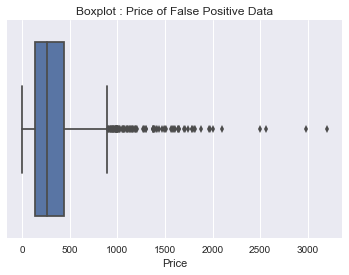

In [434]:
#plotting box plot

sns.boxplot([false_positive_price1])
plt.xlabel('Price')
plt.title("Boxplot : Price of False Positive Data")
plt.show()

**1.6.1.7 Plotting pdf with the "teacher_number_of_previously_posted_projects" for the "false positive data points"**

In [435]:
#getting the teacher_number_of_previously_posted_projects for the alse positive data points
false_positive_teacher_number_of_previously_posted_projects1= []
for i in false_positive_data:
    false_positive_teacher_number_of_previously_posted_projects1.append(x_test['teacher_number_of_previously_posted_projects'].values[i])
    
#checking if the false positive value count matches with that on confusion matrix    
print(len(false_positive_teacher_number_of_previously_posted_projects1))

1710


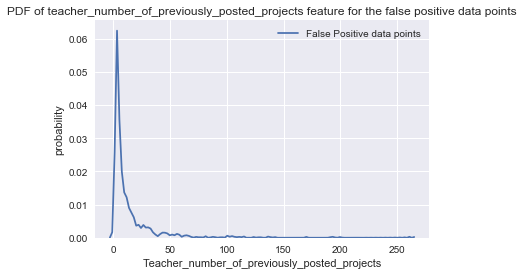

In [436]:
#Plotting pdf

sns.distplot(false_positive_teacher_number_of_previously_posted_projects1, hist=False, label="False Positive data points")
plt.title("PDF of teacher_number_of_previously_posted_projects feature for the false positive data points")
plt.xlabel('Teacher_number_of_previously_posted_projects')
plt.ylabel('probability')
plt.legend()
plt.show()

**1.7 Concatenating features : Set 2 (categorical, numerical features + essay (TFIDF W2V) + Sentiment scores(essay))**

In [437]:
#Using hstack to conact the features

from scipy.sparse import hstack
x_train_set2 = hstack((x_train_no_pre_projects_normalized,x_train_price_normalized,x_train_pos_normalized,x_train_neg_normalized,x_train_neu_normalized,x_train_compound_normalized,x_train_school_state_encoded,x_train_teacher_prefix_encoded,x_train_project_grade_category_encoded,x_train_clean_categories_encoded,x_train_clean_subcategories_encoded,tfidf_w2v_essay_x_train)).tocsr()
x_test_set2 = hstack((x_test_no_pre_projects_normalized,x_test_price_normalized,x_test_pos_normalized,x_test_neg_normalized,x_test_neu_normalized,x_test_compound_normalized,x_test_school_state_encoded,x_test_teacher_prefix_encoded,x_test_project_grade_category_encoded,x_test_clean_categories_encoded,x_test_clean_subcategories_encoded,tfidf_w2v_essay_x_test)).tocsr()

print("Concated Data Matrix")

print(x_train_set2.shape,y_train.shape)
print(x_test_set2.shape,y_test.shape)

Concated Data Matrix
(76473, 405) (76473,)
(32775, 405) (32775,)


**1.7.1 hyper paramter tuning on Set 2**

In [438]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

DT_2 = DecisionTreeClassifier(class_weight= 'balanced')

#best `depth` in range [1, 3, 10, 30], and the best `min_samples_split` in range [5, 10, 100, 500]
#Parameters for GridSearchCV

max_depth = [1, 3, 10, 30]
min_samples_split = [5,10,100,500]

parameters = {"max_depth" :[1, 3, 10, 30], "min_samples_split" : [5,10,100,500]}

clf_2 = GridSearchCV(DT_2, parameters, cv=3, scoring='roc_auc',return_train_score = True)
clf_2.fit(x_train_set2,y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 3, 10, 30], 'min_samples_split': [5, 10, 100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [439]:
#interpreting the results of GridSearchCV
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html 

print("best score :",clf_2.best_score_)
print("best parameter:",clf_2.best_params_)

best score : 0.6050706759909061
best parameter: {'max_depth': 10, 'min_samples_split': 500}


In [440]:
#Checking the Train and Test AUC scores
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

print('Train AUC scores:')
print(clf_2.cv_results_['mean_train_score'])

print('Test AUC scores:')
print(clf_2.cv_results_['mean_test_score'])

Train AUC scores:
[0.5561906  0.5561906  0.5561906  0.5561906  0.6112386  0.6112386
 0.6112386  0.6112386  0.81592618 0.81495486 0.78681524 0.72518995
 0.99808641 0.99603645 0.90055918 0.74429369]
Test AUC scores:
[0.55005519 0.55005519 0.55005519 0.55005519 0.59910711 0.59910711
 0.59910711 0.59910711 0.58129792 0.58209255 0.58597692 0.60507068
 0.53302974 0.53483472 0.56196136 0.60082234]


In [441]:
#creating dataframe to summarize the results of GridSearchCV
results2 = pd.DataFrame.from_dict(clf_2.cv_results_)
results2.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,4.172234,0.291400,0.312276,0.066472,1,5,"{'max_depth': 1, 'min_samples_split': 5}",0.552967,0.550271,0.546928,0.550055,0.002470,11,0.557390,0.554117,0.557065,0.556191,0.001472
1,4.348329,0.308853,0.316794,0.052018,1,10,"{'max_depth': 1, 'min_samples_split': 10}",0.552967,0.550271,0.546928,0.550055,0.002470,11,0.557390,0.554117,0.557065,0.556191,0.001472
2,3.786622,0.081909,0.279957,0.007204,1,100,"{'max_depth': 1, 'min_samples_split': 100}",0.552967,0.550271,0.546928,0.550055,0.002470,11,0.557390,0.554117,0.557065,0.556191,0.001472
3,3.685667,0.037263,0.269390,0.010071,1,500,"{'max_depth': 1, 'min_samples_split': 500}",0.552967,0.550271,0.546928,0.550055,0.002470,11,0.557390,0.554117,0.557065,0.556191,0.001472
4,11.537225,1.341596,0.325261,0.035563,3,5,"{'max_depth': 3, 'min_samples_split': 5}",0.598575,0.602492,0.596254,0.599107,0.002574,3,0.613244,0.608408,0.612063,0.611239,0.002059


**1.7.1.1 Plotting the results using heatmap**

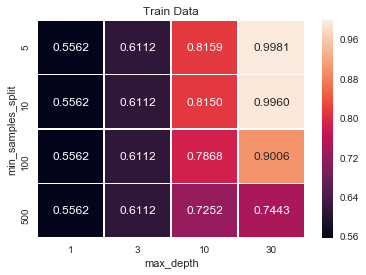

In [442]:
#heatmaps with rows as min_sample_split, columns as max_depth, and values inside the cell representing AUC Score
#https://seaborn.pydata.org/generated/seaborn.heatmap.html 

np.random.seed(0)
sns.set()

#heatmap on train data
heatmap_data2 = pd.DataFrame({'min_samples_split': results2["param_min_samples_split"], 'max_depth': results2["param_max_depth"] , 'Z': results2["mean_train_score"]})
heatmap_data2 = heatmap_data2.pivot("min_samples_split","max_depth","Z")
hm= sns.heatmap(heatmap_data2, annot= True, fmt= ".4f",linewidths=.5)

plt.title("Train Data")
plt.show()

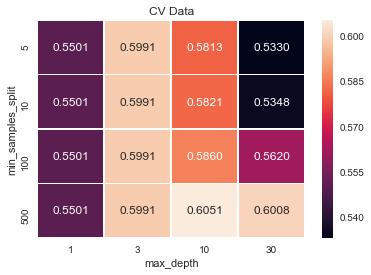

In [443]:
#heatmap on cv data
heatmap_data2 = pd.DataFrame({'min_samples_split': results2["param_min_samples_split"], 'max_depth': results2["param_max_depth"] , 'Z': results2["mean_test_score"]})
heatmap_data2 = heatmap_data2.pivot("min_samples_split","max_depth","Z")
hm= sns.heatmap(heatmap_data2, annot= True, fmt= ".4f",linewidths=.5)

plt.title("CV Data")
plt.show()

**1.7.1.2 Finding best parameters and fit the model**

In [444]:
#Finding the best parameters from classifier clf_2

best_max_depth= clf_2.best_params_['max_depth']
best_min_samples_split= clf_2.best_params_['min_samples_split']

print("best_max_depth= ",best_max_depth)
print("best_min_samples_split= ",best_min_samples_split)

best_max_depth=  10
best_min_samples_split=  500


In [445]:
#https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

DT_set2 = DecisionTreeClassifier(max_depth= best_max_depth, min_samples_split= best_min_samples_split ,class_weight='balanced')
DT_set2.fit(x_train_set2,y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

**1.7.1.3 Plotting ROC-AUC curve using predict proba method **

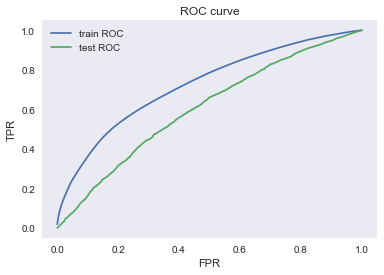

In [446]:
y_train_predicted = DT_set2.predict_proba(x_train_set2)[:,1] 
y_test_predicted = DT_set2.predict_proba(x_test_set2)[:,1]
ytest_predicted = DT_set2.predict(x_test_set2)

train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_predicted)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_predicted)

plt.plot(train_fpr, train_tpr,label="train ROC")
plt.plot(test_fpr, test_tpr,label="test ROC")
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.grid()
plt.show()


In [447]:
#Finding the area under curve ROC = AUC

train_AUC = auc(train_fpr, train_tpr)
test_AUC = auc(test_fpr, test_tpr)

print("AUC for train data :",train_AUC)
print("AUC for test data :",test_AUC)

AUC for train data : 0.7242936485715146
AUC for test data : 0.6044231121604345


**1.7.1.4 Confusion Matrix**

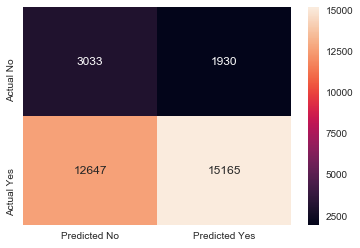

In [448]:
from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(y_test, ytest_predicted)
sns.heatmap(cm_test, annot=True,fmt="d",xticklabels= ['Predicted No', 'Predicted Yes'], yticklabels= ['Actual No','Actual Yes'])

In [449]:
#Getting all the false positive values

false_positive_data2 = []
for i in range (len(y_test)):
    if (y_test[i] == 0) & (ytest_predicted[i] == 1):
        false_positive_data2.append(i)

#checking if the false positive value count matches with that on confusion matrix
print(len(false_positive_data2))

1930


In [450]:
#getting the corresponding false positive words from "essay"
false_positive_essay2= []
for i in false_positive_data2:
    false_positive_essay2.append(x_test['essay'].values[i])
    
#checking if the false positive value count matches with that on confusion matrix    
print(len(false_positive_essay2))

1930


**1.7.1.5 Plotting WordCloud with the false positive data points on essay feature**

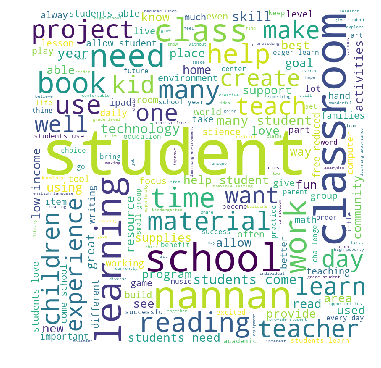

In [451]:
# https://www.geeksforgeeks.org/generating-word-cloud-python/

from wordcloud import WordCloud, STOPWORDS
comment_words = ''
stopwords = set(STOPWORDS)
# iterating through false positive words in essay
for val in false_positive_essay2:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converting each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plotting the WordCloud image                      
plt.figure(figsize = (5,5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

**1.7.1.6 box plot with the "price"of the "false positive data points"**

In [452]:
#getting the price corresponding to false positive points
false_positive_price2= []
for i in false_positive_data2:
    false_positive_price2.append(x_test['price'].values[i])
    
#checking if the false positive value count matches with that on confusion matrix    
print(len(false_positive_price2))

1930


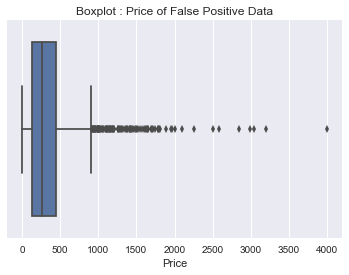

In [453]:
#plotting box plot

sns.boxplot([false_positive_price2])
plt.xlabel('Price')
plt.title("Boxplot : Price of False Positive Data")
plt.show()

**1.7.1.7 Plotting pdf with the "teacher_number_of_previously_posted_projects" for the "false positive data points"**

In [454]:
#getting the teacher_number_of_previously_posted_projects for the alse positive data points
false_positive_teacher_number_of_previously_posted_projects2= []
for i in false_positive_data2:
    false_positive_teacher_number_of_previously_posted_projects2.append(x_test['teacher_number_of_previously_posted_projects'].values[i])
    
#checking if the false positive value count matches with that on confusion matrix    
print(len(false_positive_teacher_number_of_previously_posted_projects2))

1930


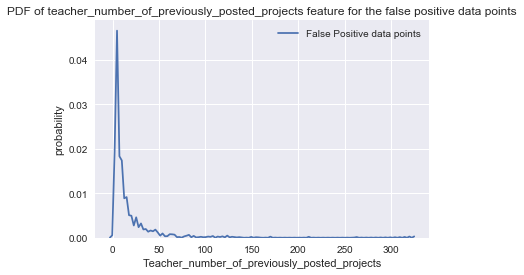

In [455]:
#Plotting pdf

sns.distplot(false_positive_teacher_number_of_previously_posted_projects2, hist=False, label="False Positive data points")
plt.title("PDF of teacher_number_of_previously_posted_projects feature for the false positive data points")
plt.xlabel('Teacher_number_of_previously_posted_projects')
plt.ylabel('probability')
plt.legend()
plt.show()

# 2.Decision Tree with non zero feature importance

**2.1 Finding features with non-zero feature importance**

In [456]:
#the new decision tree
DT_3 = DecisionTreeClassifier(class_weight = 'balanced',max_depth=None)
DT_3 = DT_3.fit(x_train_set1,y_train)

In [457]:
#getting the non zero feature importances using feature_importances_

index = []
non_zero_features = 0

for i in range (len(DT_3.feature_importances_)):
    if DT_3.feature_importances_[i] != 0:
        index.append(i)
        non_zero_features +=1

In [458]:
print("Number of non zero features:")
non_zero_features

Number of non zero features:


2429

In [459]:
#Fetching the non zero feature importance and creating new train data
imp_features =[]
for i in tqdm(index):
    imp_features.append(x_train_set1[:,i])

x_train_set3 = hstack(imp_features)    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2429/2429 [01:01<00:00, 39.23it/s]


In [460]:
x_train_set3.shape

(76473, 2429)

In [461]:
##Fetching the non zero feature importance and creating new test data
imp_features =[]
for i in tqdm(index):
    imp_features.append(x_test_set1[:,i])

x_test_set3 = hstack(imp_features)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2429/2429 [00:27<00:00, 89.11it/s]


In [462]:
x_test_set3.shape

(32775, 2429)

**2.2 hyper paramter tuning on Set 3**

In [463]:
# best `min_samples_split` in range [5, 10, 100, 500]
#Parameters for GridSearchCV

dt = DecisionTreeClassifier(class_weight= 'balanced')

#best `depth` in range [1, 3, 10, 30], and the best `min_samples_split` in range [5, 10, 100, 500]
#Parameters for GridSearchCV

max_depth = [1, 3, 10, 30]
min_samples_split = [5,10,100,500]

parameters = {"max_depth" :[1, 3, 10, 30], "min_samples_split" : [5,10,100,500]}

clf_3 = GridSearchCV(dt, parameters, cv=3, scoring='roc_auc',return_train_score = True)
clf_3.fit(x_train_set3,y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 3, 10, 30], 'min_samples_split': [5, 10, 100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [464]:
#interpreting the results of GridSearchCV
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html 

print("best score :",clf_3.best_score_)
print("best parameter:",clf_3.best_params_)

best score : 0.6290163631232419
best parameter: {'max_depth': 10, 'min_samples_split': 500}


In [465]:
#Checking the Train and Test AUC scores
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

print('Train AUC scores:')
print(clf_3.cv_results_['mean_train_score'])

print('Test AUC scores:')
print(clf_3.cv_results_['mean_test_score'])

Train AUC scores:
[0.5529175  0.5529175  0.5529175  0.5529175  0.5938408  0.5938408
 0.5938408  0.5938408  0.71526123 0.71415657 0.70159952 0.68434409
 0.94524735 0.93717689 0.87193626 0.79506864]
Test AUC scores:
[0.55241595 0.55241595 0.55241595 0.55241595 0.58566437 0.58566437
 0.58566437 0.58566437 0.6220634  0.62354136 0.62436718 0.62901636
 0.56567288 0.56382717 0.5815522  0.60744242]


In [466]:
#creating dataframe to summarize the results of GridSearchCV
results3 = pd.DataFrame.from_dict(clf_3.cv_results_)
results3.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,1.233019,0.035457,0.082692,0.003132,1,5,"{'max_depth': 1, 'min_samples_split': 5}",0.548004,0.555024,0.554221,0.552416,0.003137,13,0.554125,0.552064,0.552563,0.552917,0.000878
1,1.148176,0.018075,0.082521,0.004915,1,10,"{'max_depth': 1, 'min_samples_split': 10}",0.548004,0.555024,0.554221,0.552416,0.003137,13,0.554125,0.552064,0.552563,0.552917,0.000878
2,1.178751,0.002953,0.086728,0.012442,1,100,"{'max_depth': 1, 'min_samples_split': 100}",0.548004,0.555024,0.554221,0.552416,0.003137,13,0.554125,0.552064,0.552563,0.552917,0.000878
3,1.170991,0.008125,0.083620,0.002588,1,500,"{'max_depth': 1, 'min_samples_split': 500}",0.548004,0.555024,0.554221,0.552416,0.003137,13,0.554125,0.552064,0.552563,0.552917,0.000878
4,2.914328,0.031827,0.081372,0.001286,3,5,"{'max_depth': 3, 'min_samples_split': 5}",0.589623,0.581781,0.585589,0.585664,0.003202,6,0.603643,0.588913,0.588967,0.593841,0.006931


**2.2.1 Plotting the results using heatmap**

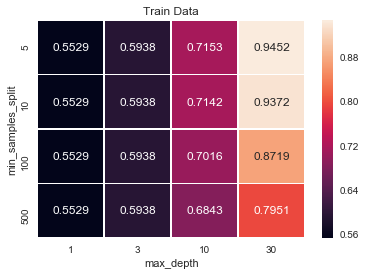

In [467]:
#heatmaps with rows as min_sample_split, columns as max_depth, and values inside the cell representing AUC Score
#https://seaborn.pydata.org/generated/seaborn.heatmap.html 

np.random.seed(0)
sns.set()

#heatmap on train data
heatmap_data3 = pd.DataFrame({'min_samples_split': results3["param_min_samples_split"], 'max_depth': results3["param_max_depth"] , 'Z': results3["mean_train_score"]})
heatmap_data3 = heatmap_data3.pivot("min_samples_split","max_depth","Z")
hm= sns.heatmap(heatmap_data3, annot= True, fmt= ".4f",linewidths=.5)

plt.title("Train Data")
plt.show()

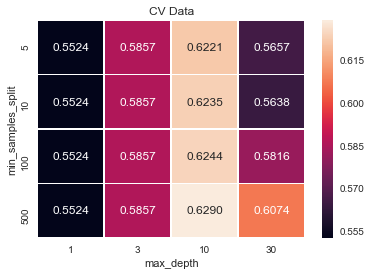

In [468]:
#heatmap on cv data
heatmap_data3 = pd.DataFrame({'min_samples_split': results3["param_min_samples_split"], 'max_depth': results3["param_max_depth"] , 'Z': results3["mean_test_score"]})
heatmap_data3 = heatmap_data3.pivot("min_samples_split","max_depth","Z")
hm= sns.heatmap(heatmap_data3, annot= True, fmt= ".4f",linewidths=.5)

plt.title("CV Data")
plt.show()

**2.2.2 Finding best parameters and fit the model**

In [469]:
#Finding the best parameters from classifier clf_3

best_max_depth= clf_3.best_params_['max_depth']
best_min_samples_split= clf_3.best_params_['min_samples_split']

print("best_max_depth= ",best_max_depth)
print("best_min_samples_split= ",best_min_samples_split)

best_max_depth=  10
best_min_samples_split=  500


In [470]:
#https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

DT_set3 = DecisionTreeClassifier(max_depth= best_max_depth, min_samples_split= best_min_samples_split ,class_weight='balanced')
DT_set3.fit(x_train_set3,y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

**2.2.3 Plotting ROC-AUC curve using predict proba method**

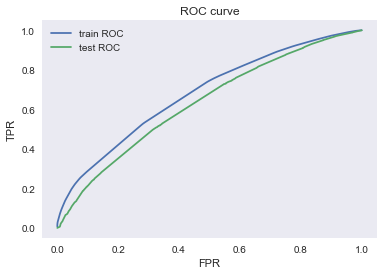

In [471]:
y_train_predicted1 = DT_set3.predict_proba(x_train_set3)[:,1] 
y_test_predicted1 = DT_set3.predict_proba(x_test_set3)[:,1]
ytest_predicted1 = DT_set3.predict(x_test_set3)

train_fpr1, train_tpr1, train_thresholds1 = roc_curve(y_train, y_train_predicted1)
test_fpr1, test_tpr1, test_thresholds1 = roc_curve(y_test, y_test_predicted1)

plt.plot(train_fpr1, train_tpr1,label="train ROC")
plt.plot(test_fpr1, test_tpr1,label="test ROC")
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.grid()
plt.show()

In [472]:
#Finding the area under curve ROC = AUC

train_AUC = auc(train_fpr1, train_tpr1)
test_AUC = auc(test_fpr1, test_tpr1)

print("AUC for train data :",train_AUC)
print("AUC for test data :",test_AUC)

AUC for train data : 0.6793616564918918
AUC for test data : 0.6303039153043322


**2.2.4 Confusion Matrix**

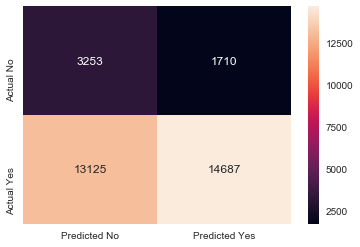

In [473]:
from sklearn.metrics import confusion_matrix
cm_test1 = confusion_matrix(y_test, ytest_predicted1)
sns.heatmap(cm_test1, annot=True,fmt="d",xticklabels= ['Predicted No', 'Predicted Yes'], yticklabels= ['Actual No','Actual Yes'])

In [475]:
#Getting all the false positive values

false_positive_data3 = []
for i in range (len(y_test)):
    if (y_test[i] == 0) & (ytest_predicted1[i] == 1):
        false_positive_data3.append(i)

#checking if the false positive value count matches with that on confusion matrix
print(len(false_positive_data3))

1710


In [476]:
#getting the corresponding false positive words from "essay"
false_positive_essay3= []
for i in false_positive_data3:
    false_positive_essay3.append(x_test['essay'].values[i])
    
#checking if the false positive value count matches with that on confusion matrix    
print(len(false_positive_essay3))

1710


**2.2.5 Plotting WordCloud with the false positive data points on essay feature**

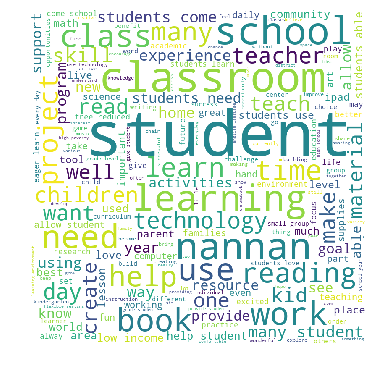

In [477]:
# https://www.geeksforgeeks.org/generating-word-cloud-python/

from wordcloud import WordCloud, STOPWORDS
comment_words = ''
stopwords = set(STOPWORDS)
# iterating through false positive words in essay
for val in false_positive_essay3:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converting each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plotting the WordCloud image                      
plt.figure(figsize = (5,5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

**2.2.6 box plot with the "price"of the "false positive data points"**

In [478]:
#getting the price corresponding to false positive points
false_positive_price3= []
for i in false_positive_data3:
    false_positive_price3.append(x_test['price'].values[i])
    
#checking if the false positive value count matches with that on confusion matrix    
print(len(false_positive_price3))

1710


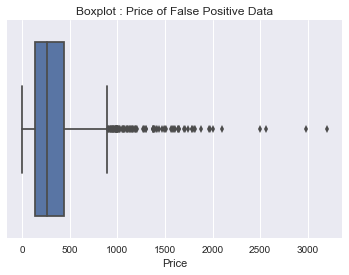

In [479]:
#plotting box plot

sns.boxplot([false_positive_price3])
plt.xlabel('Price')
plt.title("Boxplot : Price of False Positive Data")
plt.show()

**2.2.7 Plotting pdf with the "teacher_number_of_previously_posted_projects" for the "false positive data points"**

In [480]:
#getting the teacher_number_of_previously_posted_projects for the alse positive data points
false_positive_teacher_number_of_previously_posted_projects3= []
for i in false_positive_data3:
    false_positive_teacher_number_of_previously_posted_projects3.append(x_test['teacher_number_of_previously_posted_projects'].values[i])
    
#checking if the false positive value count matches with that on confusion matrix    
print(len(false_positive_teacher_number_of_previously_posted_projects3))

1710


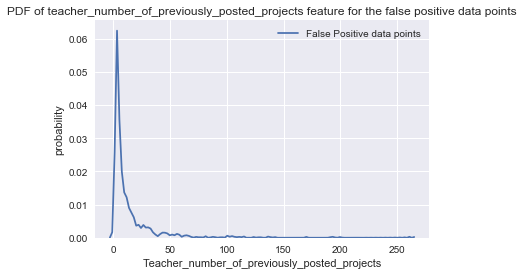

In [481]:
#Plotting pdf

sns.distplot(false_positive_teacher_number_of_previously_posted_projects3, hist=False, label="False Positive data points")
plt.title("PDF of teacher_number_of_previously_posted_projects feature for the false positive data points")
plt.xlabel('Teacher_number_of_previously_posted_projects')
plt.ylabel('probability')
plt.legend()
plt.show()

**2.3 Summary of Results**

In [487]:
#Tabulating the results using PtrettyTable
#https://pypi.org/project/prettytable/

from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Max_Depth", "Min_Samples_Split","test_AUC"]
x.add_row(["TFIDF", "Decision Tree", "5", "500","0.630"])
x.add_row(["TFIDF_W2V", "Decision Tree", "5", "500","0.604"])
x.add_row(["TFIDF with Feature Importance", "Decision Tree", "5", "500","0.630"])
print(x)

+-------------------------------+---------------+-----------+-------------------+----------+
|           Vectorizer          |     Model     | Max_Depth | Min_Samples_Split | test_AUC |
+-------------------------------+---------------+-----------+-------------------+----------+
|             TFIDF             | Decision Tree |     5     |        500        |  0.630   |
|           TFIDF_W2V           | Decision Tree |     5     |        500        |  0.604   |
| TFIDF with Feature Importance | Decision Tree |     5     |        500        |  0.630   |
+-------------------------------+---------------+-----------+-------------------+----------+
